In [60]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)

In [61]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital', 'occupation', 'relationship', 'race', 'gender', 'capgain', 'caploss', 'hours', 'country', 'income']
df_train = pd.read_csv('adult.data', names=cols, sep=",")
df_test = pd.read_csv('adult.test', names=cols, sep=",")

**One-hot encoding**

In [62]:
 def one_hot_encode(df):
    df.isin(['?']).sum(axis=0)

    # replace missing values (?) to nan and then drop the columns
    df['country'] = df['country'].replace('?',np.nan)
    df['workclass'] = df['workclass'].replace('?',np.nan)
    df['occupation'] = df['occupation'].replace('?',np.nan)

    # dropping the NaN rows now
    df.dropna(how='any',inplace=True)
    df['income'] = df['income'].map({'<=50K': 0, '>50K': 1}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['gender'], prefix='gender')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['race'], prefix='race')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['workclass'], prefix='workclass')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['relationship'], prefix='relationship')],axis=1)
    df = pd.concat([df, pd.get_dummies(df['occupation'], prefix='occupation')],axis=1)

    df = df.drop(columns=['workclass', 'gender', 'fnlwgt', 'education', 'occupation', \
                      'relationship', 'marital', 'race', 'country', 'capgain', \
                      'caploss'])
    return df

# one-hot encoding (for regression mdoels)
df_train = one_hot_encode(df_train)
df_test = one_hot_encode(df_test)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender_Female'=1
# privileged: 'gender_Male'=1

**Parametric Model**

In [63]:
X_train = df_train.drop(columns='income')
y_train = df_train['income']

X_test = df_test.drop(columns='income')
y_test = df_test['income']

# size=1000
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute statistical parity difference**

In [6]:
def computeFairness(y_pred, X_test): 
    protected_idx = X_test[X_test['gender_Female']==1].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['gender_Male']==1].index
    numPrivileged = len(privileged_idx)
    
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    spd = p_protected - p_privileged
    return spd

**Influence of points computed using ground truth**

In [7]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig) - spd_0
        delta_spd.append(delta_spd_i)
    
    return delta_spd

**Loss function** (Log loss for logistic regression)

In [8]:
def logistic_loss(y_true, y_pred):
    loss = 0
    for i in range(len(y_true)):
        if (y_pred[i][1] != 0 and y_pred[i][0] != 0):
            loss += - y_true[i] * math.log(y_pred[i][1]) - (1 - y_true[i]) * math.log(y_pred[i][0])
    loss /= len(y_true)
    return loss

**First-order derivative of loss function at z with respect to model parameters**

(Pre-computed for all training points)

In [9]:
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

**Hessian: Second-order partial derivative of loss function with respect to model parameters**

(Pre-computed for all training points)

In [10]:
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i+1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [11]:
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

**Computing $v=\nabla($Statistical parity difference$)$**

In [12]:
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numProtected = X_test_orig['gender_Female'].sum()
    numPrivileged = X_test_orig['gender_Male'].sum()
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['gender_Male'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['gender_Female'] == 1:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [13]:
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

**First-order influence computation**

In [14]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

**Second-order Influence function computation**

(For any group of points U)

In [15]:
def second_order_influence(X_train, v1, U, size, del_L_del_theta, hessian_all_points):
    u = len(U) 
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(v1)
    
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_all = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
#         if (i%1000==0):
#             print(i)
        del_L_del_theta_hinv = np.add(del_L_del_theta_hinv, hessian_vector_product(num_params, s, size, del_L_del_theta[idx], hessian_all_points))
        hessian_all = np.add(hessian_all, hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    term1 = c1 * del_L_del_theta_sum
    term2 = c2 * np.dot(hessian_all, del_L_del_theta_hinv)

    I = np.dot(v1.transpose(), (term1 + term2))
    return I

**Determining k for particular drops in log-loss**

In [19]:
# removing k data points that have the max. influence on bias
# identified k for which 10% drop in log-loss, 20% drop, 30% drop
def accuracy_fairness_k(X_train, y_train, X_test, y_test, X_test_orig):
    remove_idx = []
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)
    loss_0 = logistic_loss(y_test, y_pred)
    print(spd_0)
    print(loss_0)
    for k in range(len(sort_index)):
        print(k)
        remove_idx.append(sort_index[k])
        X_removed = np.delete(X_train, remove_idx, 0)
        y_removed = y_train.drop(index=remove_idx, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_k = (computeFairness(y_pred, X_test_orig) - spd_0)/spd_0
        delta_loss_k = (logistic_loss(y_test, y_pred) - loss_0)/loss_0
        print("Loss fraction: ", delta_loss_k)
        print("Spd fraction: ", delta_spd_k)    

accuracy_fairness_k(X_train, y_train, X_test, y_test, X_test_orig)

-0.20059371090978573
0.360972684923813
0
Loss fraction:  0.002565293608663658
Spd fraction:  -0.0008108503392545257
1
Loss fraction:  0.0026679348810044307
Spd fraction:  -0.0012780590475225402
2
Loss fraction:  0.0026764161224010936
Spd fraction:  -0.0017619151959095472
3
Loss fraction:  0.002661620099908332
Spd fraction:  -0.002168835700143185
4
Loss fraction:  0.002669600220760317
Spd fraction:  -0.0026501544367761296
5
Loss fraction:  0.0026716827358680612
Spd fraction:  -0.0031300578852972378
6
Loss fraction:  0.0026858318693879623
Spd fraction:  -0.0034783944084144404
7
Loss fraction:  0.0027004085990388733
Spd fraction:  -0.003939819541672199
8
Loss fraction:  0.002711092963733386
Spd fraction:  -0.004398062851621458
9
Loss fraction:  0.0027436534709481476
Spd fraction:  -0.00477703366821688
10
Loss fraction:  0.0027609655926304046
Spd fraction:  -0.0053037018130847515
11
Loss fraction:  0.0027632693694565565
Spd fraction:  -0.005692368919213939
12
Loss fraction:  0.002773563313

Loss fraction:  0.0053359562646106305
Spd fraction:  -0.04497966985035464
107
Loss fraction:  0.005368805587048863
Spd fraction:  -0.04529104571167256
108
Loss fraction:  0.005408155703337994
Spd fraction:  -0.04574002024926578
109
Loss fraction:  0.005449033092704771
Spd fraction:  -0.0461345148562324
110
Loss fraction:  0.005489894294206175
Spd fraction:  -0.0465046447350356
111
Loss fraction:  0.005529438139558604
Spd fraction:  -0.04690252768913556
112
Loss fraction:  0.005578856297962854
Spd fraction:  -0.0472550630039644
113
Loss fraction:  0.005623993560468086
Spd fraction:  -0.0477516149951831
114
Loss fraction:  0.005663215246336552
Spd fraction:  -0.04816489561089531
115
Loss fraction:  0.005704448176110828
Spd fraction:  -0.048593832559188664
116
Loss fraction:  0.005742247159374187
Spd fraction:  -0.0490021331724748
117
Loss fraction:  0.0057866869091119
Spd fraction:  -0.049380488446327045
118
Loss fraction:  0.005827565572321329
Spd fraction:  -0.049780414904539216
119
Lo

Loss fraction:  0.00981000880054639
Spd fraction:  -0.08466466528126484
214
Loss fraction:  0.009819013212536813
Spd fraction:  -0.08488905185533863
215
Loss fraction:  0.009898073398250582
Spd fraction:  -0.08518869594413829
216
Loss fraction:  0.009953164969787036
Spd fraction:  -0.08558178540226043
217
Loss fraction:  0.010019447623641209
Spd fraction:  -0.08585208265905278
218
Loss fraction:  0.0100336243109119
Spd fraction:  -0.08615903274559233
219
Loss fraction:  0.01007872972907703
Spd fraction:  -0.08649781017619287
220
Loss fraction:  0.010140570488074728
Spd fraction:  -0.08690635934452888
221
Loss fraction:  0.010145874590376504
Spd fraction:  -0.08721175916092448
222
Loss fraction:  0.010217051742344899
Spd fraction:  -0.0876056666713446
223
Loss fraction:  0.010282297166771771
Spd fraction:  -0.08801335384386134
224
Loss fraction:  0.010252578606233853
Spd fraction:  -0.08828600811367933
225
Loss fraction:  0.01024527292265625
Spd fraction:  -0.08854986589241506
226
Loss 

Loss fraction:  0.013488846145034202
Spd fraction:  -0.11747941407575979
321
Loss fraction:  0.013522325640938799
Spd fraction:  -0.11774337332028736
322
Loss fraction:  0.013509051245559966
Spd fraction:  -0.11799331267530383
323
Loss fraction:  0.013502333275145181
Spd fraction:  -0.11825074722556839
324
Loss fraction:  0.013493559564967323
Spd fraction:  -0.11849698987975232
325
Loss fraction:  0.013462418742996649
Spd fraction:  -0.11875560679295652
326
Loss fraction:  0.013465965368273273
Spd fraction:  -0.1190028830931466
327
Loss fraction:  0.013551107142984915
Spd fraction:  -0.11923539564227971
328
Loss fraction:  0.013527449452710056
Spd fraction:  -0.11949019490022346
329
Loss fraction:  0.013513154735655314
Spd fraction:  -0.11976692628203002
330
Loss fraction:  0.01357508556919848
Spd fraction:  -0.12012161278215867
331
Loss fraction:  0.013606047677048105
Spd fraction:  -0.12038351235197489
332
Loss fraction:  0.013603951766135797
Spd fraction:  -0.12067481093793825
333
L

Loss fraction:  0.016881817038426897
Spd fraction:  -0.14766913351613403
428
Loss fraction:  0.01703176756393546
Spd fraction:  -0.14791110361548102
429
Loss fraction:  0.017106231670626307
Spd fraction:  -0.14825289990688745
430
Loss fraction:  0.017191145226825338
Spd fraction:  -0.14867424481837516
431
Loss fraction:  0.017274869652851778
Spd fraction:  -0.1490756606858418
432
Loss fraction:  0.017298642425984195
Spd fraction:  -0.14933039857440977
433
Loss fraction:  0.017360825029060084
Spd fraction:  -0.1495887269608077
434
Loss fraction:  0.017434012767795687
Spd fraction:  -0.14999190979845006
435
Loss fraction:  0.01748160984840721
Spd fraction:  -0.15023160284050827
436
Loss fraction:  0.01749894157642335
Spd fraction:  -0.1505123520586049
437
Loss fraction:  0.017478564951599433
Spd fraction:  -0.15075823774987945
438
Loss fraction:  0.017495415475692996
Spd fraction:  -0.15101343907786663
439
Loss fraction:  0.017503715652905344
Spd fraction:  -0.15127997845165378
440
Loss 

Loss fraction:  0.021087014829129537
Spd fraction:  -0.1774688674075927
536
Loss fraction:  0.02111781791825169
Spd fraction:  -0.17781384919879942
537
Loss fraction:  0.021132124093732715
Spd fraction:  -0.1780173849954533
538
Loss fraction:  0.02117933217806779
Spd fraction:  -0.1782414837026436
539
Loss fraction:  0.021259177901711345
Spd fraction:  -0.17858364939776897
540
Loss fraction:  0.021351440808609616
Spd fraction:  -0.17900965708650873
541
Loss fraction:  0.02138505742753881
Spd fraction:  -0.1792503840119961
542
Loss fraction:  0.021418966243323012
Spd fraction:  -0.17948626260102193
543
Loss fraction:  0.02145369162033612
Spd fraction:  -0.17972357691912005
544
Loss fraction:  0.021497755205714984
Spd fraction:  -0.17996270585141227
545
Loss fraction:  0.021524477264151236
Spd fraction:  -0.18027443484545858
546
Loss fraction:  0.021599916237097862
Spd fraction:  -0.1805796582083593
547
Loss fraction:  0.02162602603107957
Spd fraction:  -0.18079458302601598
548
Loss frac

Loss fraction:  0.026597898000751727
Spd fraction:  -0.206528556288065
644
Loss fraction:  0.026637698831265735
Spd fraction:  -0.20676148198641353
645
Loss fraction:  0.026697925347318838
Spd fraction:  -0.20701316889456248
646
Loss fraction:  0.02683393897696764
Spd fraction:  -0.20728467570315393
647
Loss fraction:  0.027068505194428657
Spd fraction:  -0.20756368488137839
648
Loss fraction:  0.02715485091323805
Spd fraction:  -0.20796381285964607
649
Loss fraction:  0.027250141750954027
Spd fraction:  -0.20836312650186084
650
Loss fraction:  0.027279775159593296
Spd fraction:  -0.20861719673670756
651
Loss fraction:  0.027308527548756574
Spd fraction:  -0.20884372112408475
652
Loss fraction:  0.027375007114092357
Spd fraction:  -0.20906387775337174
653
Loss fraction:  0.027471851785614145
Spd fraction:  -0.20945543820661314
654
Loss fraction:  0.027569238443612466
Spd fraction:  -0.20987115011732135
655
Loss fraction:  0.027579662106822878
Spd fraction:  -0.21010720369311345
656
Los

KeyboardInterrupt: 

**Regression tree for ground truth and first-order influences (not accounting for accuracy)**

Ground truth decision tree
Influence functions decision tree


[Text(2961.7723880597014, 2548.125, 'age <= 59.5\nmse = 4.311\nsamples = 30162\nvalue = 0.0'),
 Text(1620.5597014925372, 2208.375, 'hours <= 85.5\nmse = 4.203\nsamples = 28080\nvalue = 0.027'),
 Text(888.3582089552239, 1868.625, 'age <= 35.5\nmse = 4.167\nsamples = 27957\nvalue = 0.033'),
 Text(444.17910447761193, 1528.875, 'relationship_Husband <= 0.5\nmse = 2.464\nsamples = 13691\nvalue = -0.054'),
 Text(222.08955223880596, 1189.125, 'age <= 34.5\nmse = 0.994\nsamples = 10129\nvalue = 0.023'),
 Text(111.04477611940298, 849.375, 'relationship_Wife <= 0.5\nmse = 0.906\nsamples = 9700\nvalue = 0.033'),
 Text(55.52238805970149, 509.625, 'hours <= 47.5\nmse = 0.287\nsamples = 9213\nvalue = 0.018'),
 Text(27.761194029850746, 169.875, 'mse = 0.192\nsamples = 7976\nvalue = 0.03'),
 Text(83.28358208955224, 169.875, 'mse = 0.894\nsamples = 1237\nvalue = -0.061'),
 Text(166.56716417910448, 509.625, 'age <= 24.5\nmse = 12.533\nsamples = 487\nvalue = 0.311'),
 Text(138.80597014925374, 169.875, 'm

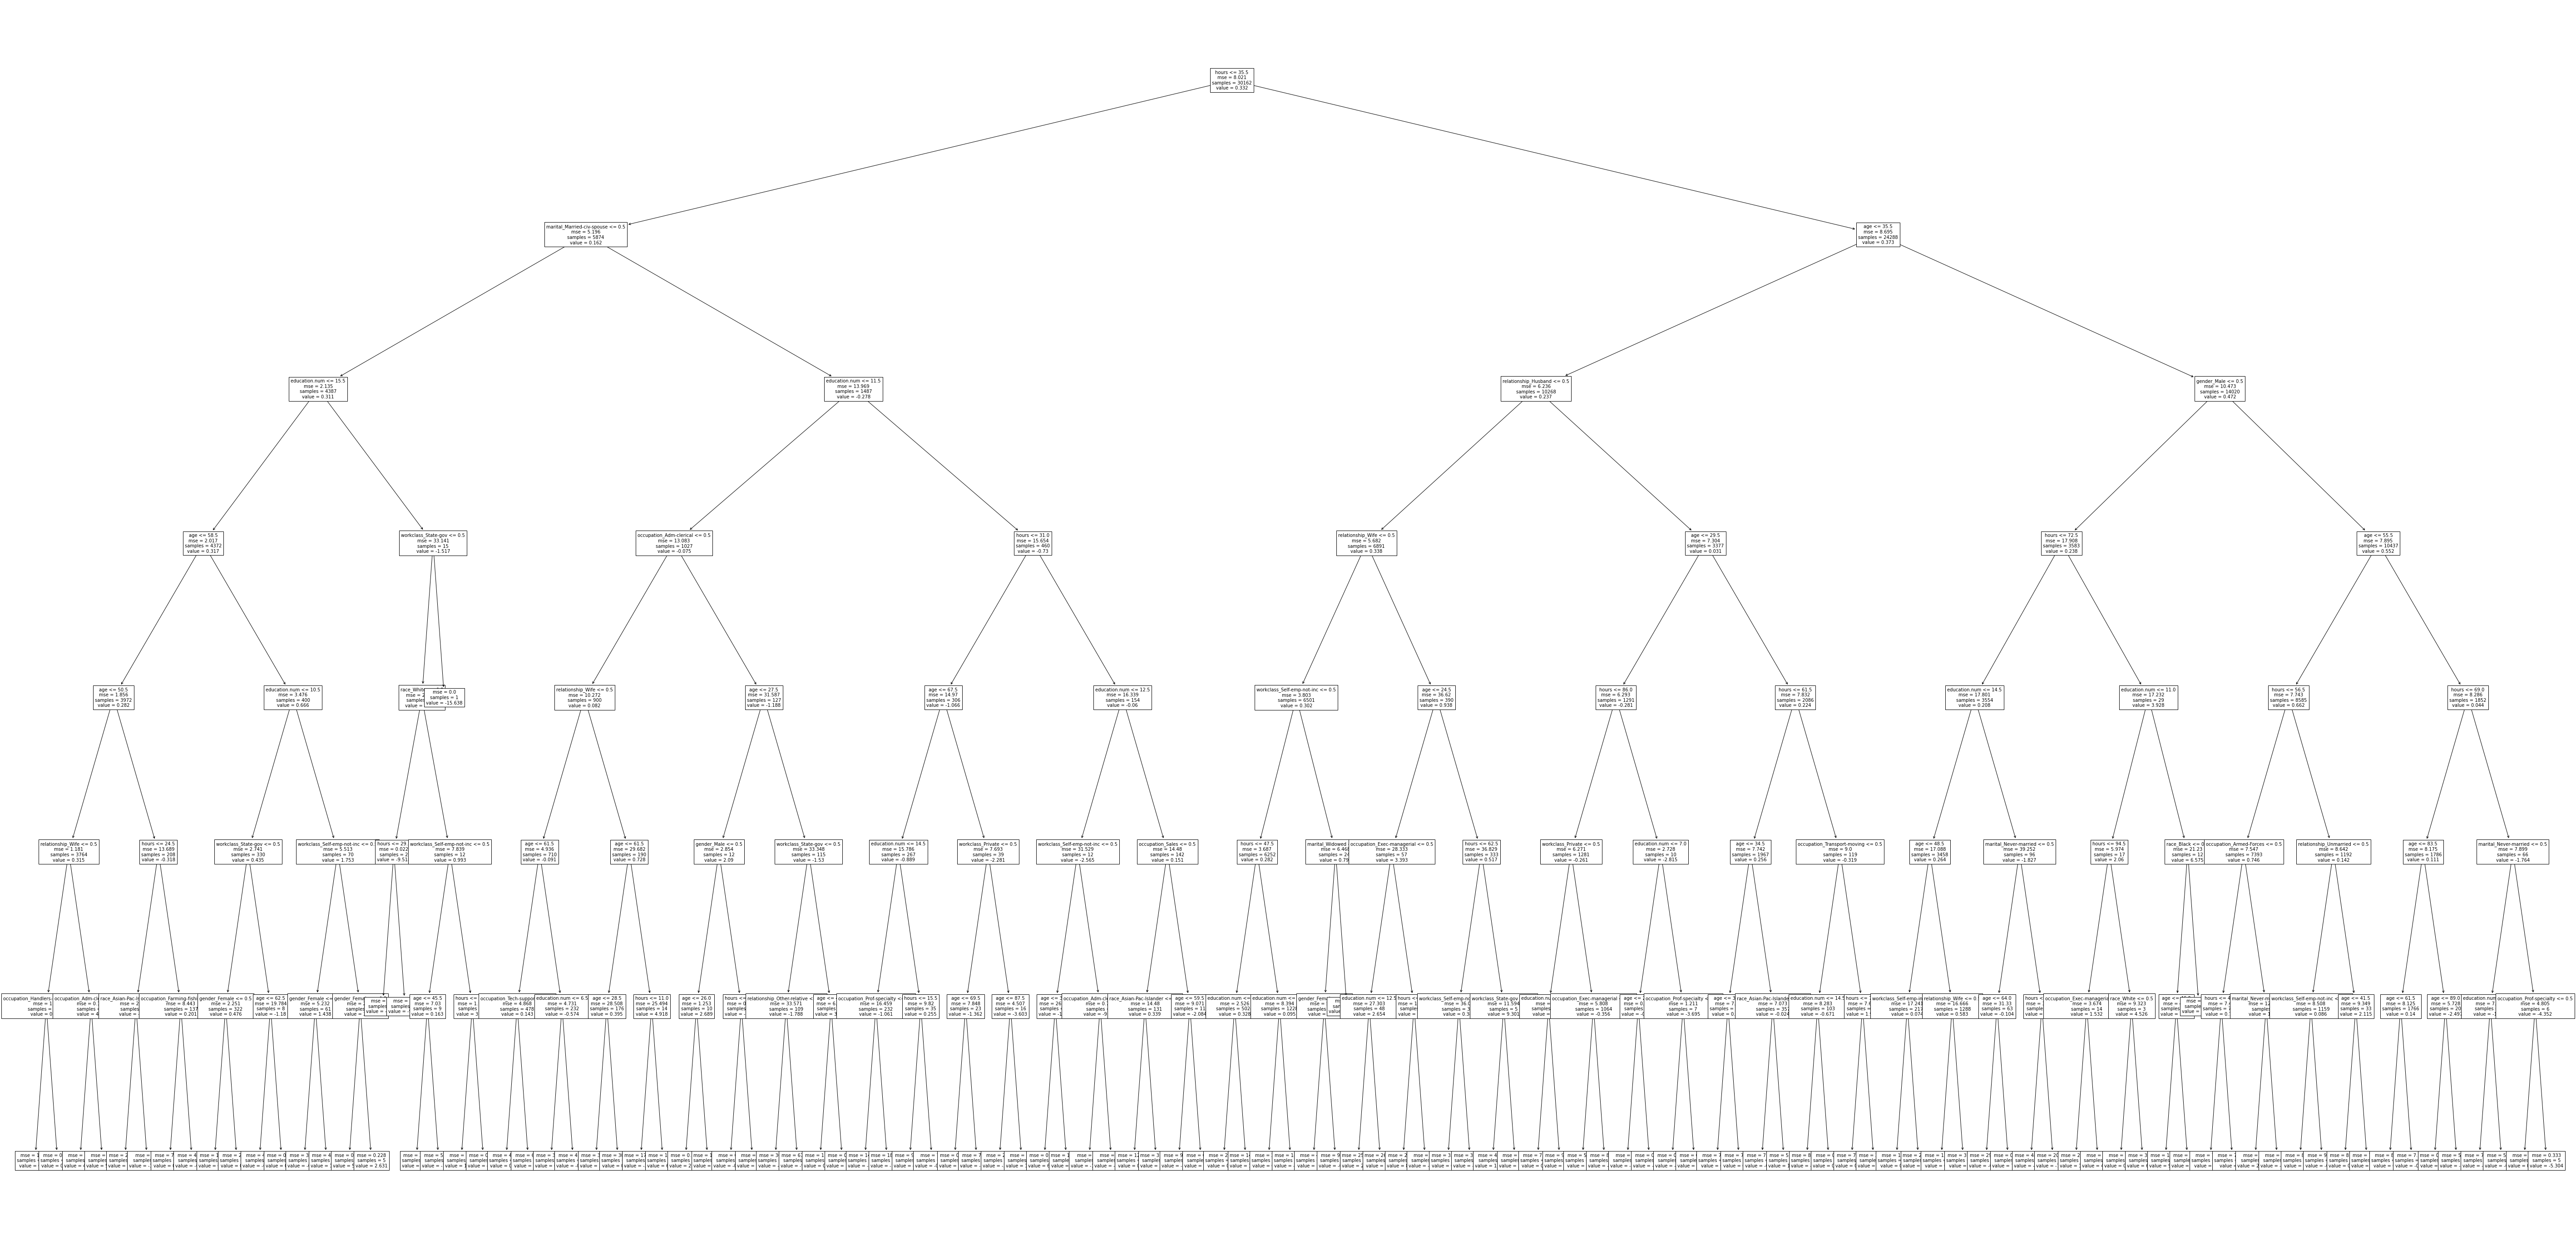

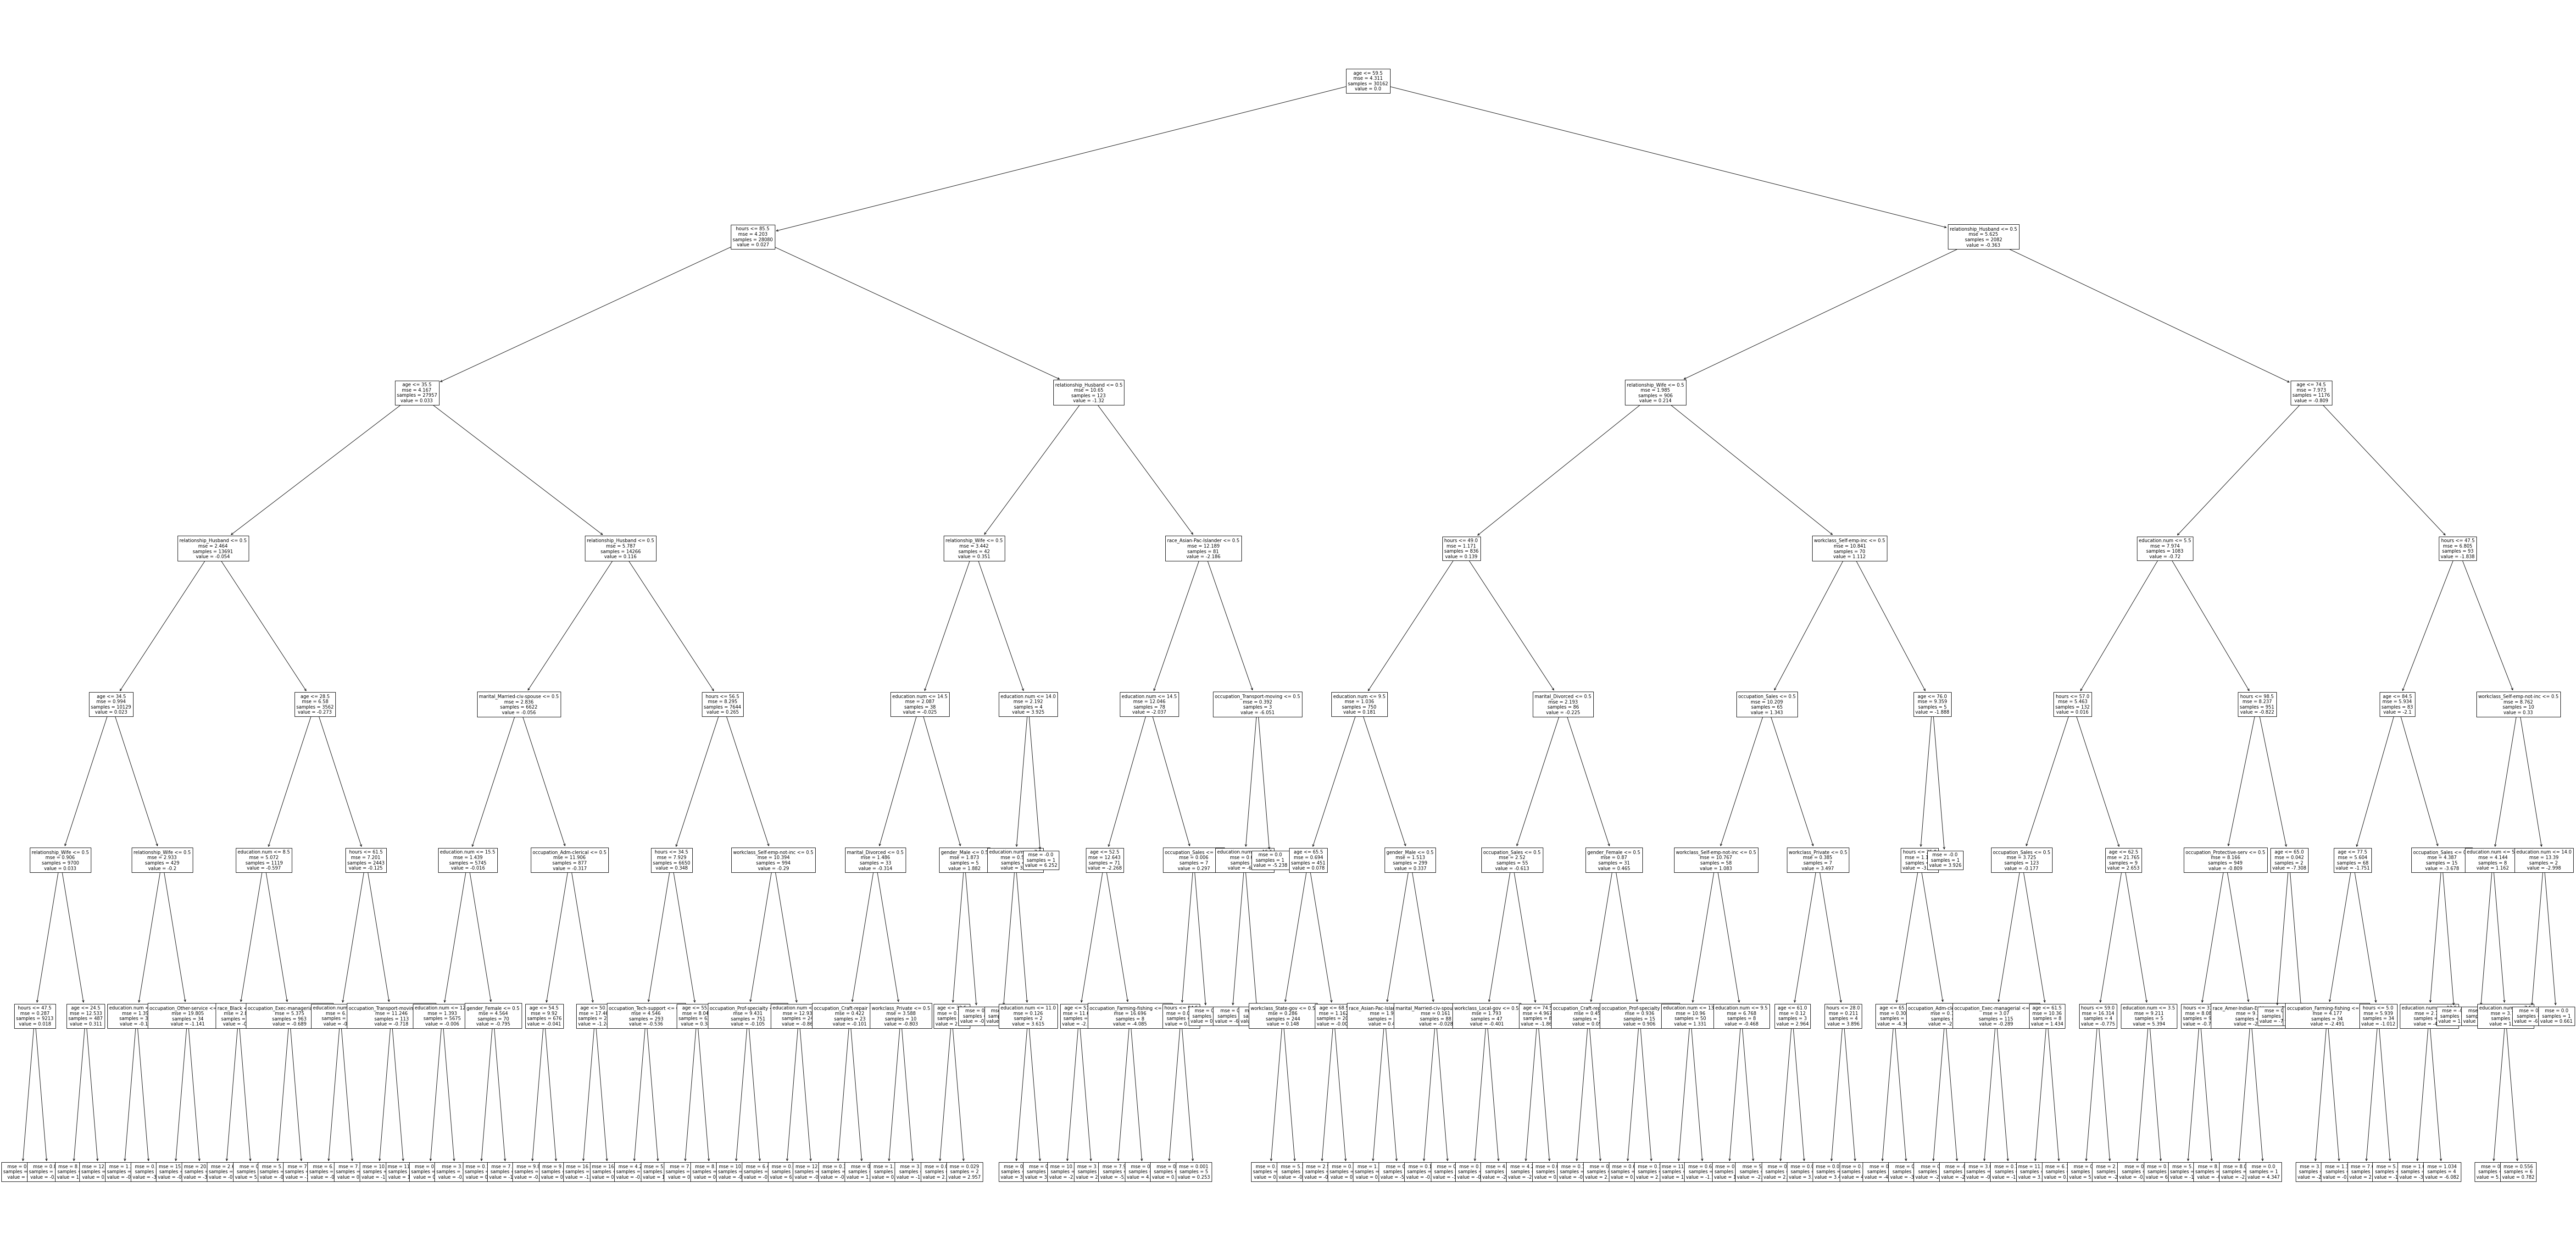

In [146]:
# Build a random forest regression model learnt on X to predict Y values
# where Y = calculated influences
# The idea is to identify attributes or predicates most important for influence computation

print("Ground truth decision tree")
norm_gt_spd = spdgt.copy()
norm_gt_spd = [float(i)*10000/sum(norm_gt_spd) for i in norm_gt_spd]
regr_gt = DecisionTreeRegressor(max_depth=7) 
regr_gt.fit(X_train_orig, norm_gt_spd)
plt.figure(figsize=(100,50))
plot_tree(regr_gt, feature_names=X_train_orig.columns, fontsize=10)

print("Influence functions decision tree")
norm_infs = infs_1.copy()
norm_infs = [float(i)/sum(norm_infs) for i in norm_infs]
regr_inf = DecisionTreeRegressor(max_depth=7) 
regr_inf.fit(X_train_orig, norm_infs)
plt.figure(figsize=(100,50))
plot_tree(regr_inf, feature_names=X_train_orig.columns, fontsize=10)

**Fairness/Accuracy change removing predicates according to the regression tree**

In [150]:
df = pd.DataFrame(data=X_train, columns=X_train_orig.columns)
# idx = df[(df['hours']>-.453) & (df['age']>-.224) &(df['gender_Male']>-.375) &(df['age']<=1.299) &(df['hours']<=1.3)].index.tolist() 
# idx = df[(df['hours']<=35.5) & (df['hours']<=3.72) & (df['age']>0.224) & (df['relationship_Husband']>0.176) & (df['hours']<=1.3)].index.tolist() 
# idx = df_train[(df_train['hours']>35.5) & (df_train['age']>35.5) & 
#                (df_train['gender_Male']>0.5) & (df_train['age']<=55.5) & 
#                (df_train['hours']<=56.5) & (df_train['occupation_Armed-Forces']>0.5)
#               & (df_train['marital_Never-married']<=.5)].index.tolist() 
idx = df_train[(df_train['age']<=59.5) 
               & (df_train['hours']<=85.5) 
               & (df_train['age']>35.5) 
               & (df_train['relationship_Husband']>0.5) 
               & (df_train['hours']<=56.5) 
               & (df_train['hours']>34.5)
               & (df_train['age']<=55.5)
              ].index.tolist() 
X_removed = np.delete(X_train, idx, 0)
y_removed = y_train.drop(index=idx, inplace=False)
clf.fit(X_removed, y_removed)
y_pred = clf.predict_proba(X_test)
spd = computeFairness(y_pred, X_test_orig)
print("Fraction of records: ", len(idx)/len(X_train))
print("% Change in fairness: ", (spd/spd_0 - 1)*100)
loss = logistic_loss(y_test, y_pred)
print("% Change in loss: ", (loss/loss_0 - 1)*100)

Fraction of records:  0.18917843644320667
% Change in fairness:  -19.119115227432225
% Change in loss:  1.7854818327251554


**Influence of top-k influential points**

In [151]:
def top_k_influence(X_train, y_train, X_test, y_test, X_test_orig, sort_index):
    remove_idx = []
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig)
    loss_0 = logistic_loss(y_test, y_pred)
    print(spd_0)
    print(loss_0)
    for k in range(len(sort_index)):
        remove_idx.append(sort_index[k])
        X_removed = np.delete(X_train, remove_idx, 0)
        y_removed = y_train.drop(index=remove_idx, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd = (computeFairness(y_pred, X_test_orig)/spd_0 - 1)*100
        delta_loss = (logistic_loss(y_test, y_pred)/loss_0 - 1)*100
        print('{}\t{}\t{}'.format(k, delta_spd, delta_loss)) 

inf_sorted_idx = np.argsort(infs_1)[::-1][:len(infs_1)]
spdgt_sorted_idx = np.argsort(spdgt)[::-1][:len(spdgt)]
top_k_influence(X_train, y_train, X_test, y_test, X_test_orig, spdgt_sorted_idx)

-0.20059371090978573
0.360972684923813
0	-0.0810850339254543	0.25652936086637546
1	-0.12780590475225395	0.26679348810043635
2	-0.17619151959095136	0.2676416122401104
3	-0.21688357001431458	0.2661620099908335
4	-0.26501544367760754	0.26696002207602376
5	-0.31300578852971883	0.2671682735868153
6	-0.34783944084144647	0.2685831869387867
7	-0.3939819541672218	0.27004085990389726
8	-0.4398062851621476	0.2711092963733286
9	-0.47770336682169123	0.2743653470948182
10	-0.5303701813084705	0.27609655926303933
11	-0.5692368919213986	0.2763269369456589
12	-0.6033494464862788	0.27735633134053916
13	-0.6484740513430176	0.27816347465758895
14	-0.6969008194865567	0.2799013033983
15	-0.7445666875889434	0.2819876747143679
16	-0.7746396872004069	0.2835646910345435
17	-0.8186812118745279	0.2845919663509333
18	-0.8595891793707011	0.28651589668065025
19	-0.9056898976841588	0.28821928799236396
20	-0.9508835924856407	0.2892410140827417
21	-0.9972560126463859	0.29128462361103225
22	-1.04281144608247	0.2930321822

195	-7.877944298260664	0.9214672825947012
196	-7.916077387859244	0.9274032109402919
197	-7.950323618842203	0.9315473755823866
198	-7.991750873922632	0.937680638974081
199	-8.028101097279484	0.9431460438586781
200	-8.062780452160878	0.9476432143024072
201	-8.090237103847297	0.951126706541694
202	-8.11989123584349	0.949984130257997
203	-8.148272264416478	0.9512821117694248
204	-8.177152069749372	0.951306419378084
205	-8.203946449130617	0.9512324841957076
206	-8.230281189404131	0.9503154215487086
207	-8.271913769509798	0.9565670445226271
208	-8.295934621217038	0.9591779059747063
209	-8.321179240501287	0.9622461762204271
210	-8.345561521766054	0.96543711337711
211	-8.384195113943072	0.9712491696842074
212	-8.42601043601492	0.9759910307545194
213	-8.466466528126482	0.9810008800546388
214	-8.488905185533858	0.9819013212536865
215	-8.518869594413825	0.9898073398250551
216	-8.558178540226047	0.9953164969787043
217	-8.585208265905276	1.0019447623641264
218	-8.615903274559233	1.0033624310911815


389	-13.6943384730431	1.5629846484475962
390	-13.721054238387486	1.564083666944427
391	-13.746710586588474	1.5698918459297273
392	-13.774792050383445	1.5814499861508402
393	-13.799349029337671	1.5842625441467417
394	-13.823127150297143	1.5844084670230574
395	-13.8521713614007	1.5951408909739895
396	-13.879659759112883	1.5956871694035035
397	-13.922229948338083	1.6039219102300217
398	-13.942220004845707	1.6022336645260538
399	-13.967728352187558	1.6025891573391071
400	-13.997836181302404	1.6023480280782376
401	-14.022582634256853	1.603836065716191
402	-14.044571797439986	1.6068951850819024
403	-14.070120700813327	1.6089995949633007
404	-14.094871736835213	1.6086993466635446
405	-14.106631515328106	1.6071079670187727
406	-14.1603832105319	1.6149322385904608
407	-14.188600393514427	1.6180330159788925
408	-14.2158749759823	1.621082883583691
409	-14.243789893249515	1.6266551865164791
410	-14.269853988369475	1.6290373160392502
411	-14.309142808917352	1.6373056752130966
412	-14.33677559335789

583	-19.044880569294385	2.3075589753650982
584	-19.06823854438947	2.3086007456305735
585	-19.09119005536989	2.313325072106087
586	-19.12962832008881	2.3209635635146775
587	-19.15248654060958	2.3224484915057353
588	-19.18127734622914	2.3301109740144987
589	-19.20665631251637	2.335016775176446
590	-19.229230575428936	2.3369871108080753
591	-19.258442479119353	2.3394136448032787
592	-19.285298855522115	2.3441258732901593
593	-19.297325475213857	2.3479793526339554
594	-19.32009269595609	2.3529099020220823
595	-19.344102023462018	2.35328585721577
596	-19.371324529302747	2.356758500660394
597	-19.391565523917663	2.3639165089332392
598	-19.426697819024508	2.3732795306036447
599	-19.455304551601984	2.374417129273776
600	-19.478186956924493	2.382334266718056
601	-19.52313700741023	2.3931490540930467
602	-19.54833442683901	2.395217689074647
603	-19.569886721241502	2.3978605280056575
604	-19.59488969852269	2.4009499933432377
605	-19.627659608309656	2.407861762954755
606	-19.648399378190508	2.4079

778	-24.351605946193477	3.66177351854442
779	-24.37497524635488	3.6655523984992167
780	-24.397243055137064	3.673788262382094
781	-24.421491001132566	3.6811674883420853
782	-24.439750242794943	3.682028981011509
783	-24.46420484922308	3.6860323898439074
784	-24.488627145361054	3.6901676974222974
785	-24.51792222454774	3.699498818014968
786	-24.54299693113121	3.705361554590203
787	-24.56477623242195	3.709724013465121
788	-24.588259334332395	3.715376528500891
789	-24.623417568620876	3.7220489429254044
790	-24.636275446109668	3.7286935147486933
791	-24.66839024655183	3.740976730352097
792	-24.68786262544196	3.744255907944849
793	-24.716072139033706	3.7502614630378517
794	-24.74254268370979	3.760763201631989
795	-24.76488226293344	3.76553093871026
796	-24.785996362516183	3.7690671594367453
797	-24.809150524823853	3.7723265916759674
798	-24.85359477582766	3.7864323175624603
799	-24.879072567057325	3.8082439626579534
800	-24.905440727405182	3.8073828856682645
801	-24.925425588872574	3.81602844

974	-29.335852495728897	5.339710327452218
975	-29.361395395666158	5.352381799231232
976	-29.373725441681987	5.357016742359444
977	-29.401184568770756	5.362867872107691
978	-29.420645020081015	5.364188442166062
979	-29.44980315088167	5.3763234174246
980	-29.48282128974753	5.386389750552012
981	-29.506930340638917	5.394800639983766
982	-29.528056124862488	5.399980468999743
983	-29.554637961977647	5.413414610679457
984	-29.577695450976172	5.427646872792513
985	-29.621244806644587	5.440478701449458
986	-29.640005594490294	5.44363531546348
987	-29.662427467086417	5.445535648187327
988	-29.685663373078075	5.450788904545889
989	-29.712692185696767	5.456318071528088
990	-29.736263317724987	5.462487197372101
991	-29.758139627686187	5.468787184917656
992	-29.787724650779047	5.471391930022795
993	-29.81609579508152	5.474403476907019
994	-29.860187905284707	5.484802442100611
995	-29.88256367932123	5.490182413363631
996	-29.903280526033814	5.491637436879659
997	-29.931433244118722	5.497553201078764

1168	-34.27826615894788	7.014850879189449
1169	-34.29965780091811	7.019322023455832
1170	-34.3171633637914	7.0247380791435
1171	-34.35288730194447	7.049365973498456
1172	-34.37465299149288	7.054743453532009
1173	-34.39794821266639	7.059732966775578
1174	-34.42177533146804	7.0744920222371555
1175	-34.464360622462905	7.086266611343306
1176	-34.48641091135842	7.091632395445502
1177	-34.50691265314517	7.096707809985148
1178	-34.531164266876324	7.104171373451806
1179	-34.554295203428644	7.110457487988997
1180	-34.57757361017594	7.120980573738089
1181	-34.59961992733741	7.126604164492156
1182	-34.642228860377976	7.140715678911791
1183	-34.6658702121094	7.149343828853327
1184	-34.692848037951194	7.15474528686495
1185	-34.717154931245744	7.163210369429862
1186	-34.74166518479975	7.172175545665849
1187	-34.785308266434456	7.188408329999785
1188	-34.81553778602243	7.209926895118968
1189	-34.83624399075384	7.2151049976615145
1190	-34.85806715991689	7.2199006064027405
1191	-34.879318913387245	7.24

1363	-39.31815040322929	8.891829935123008
1364	-39.33899672027833	8.898077471574318
1365	-39.36237543260849	8.90558008624489
1366	-39.38392079417511	8.914018809466917
1367	-39.43165405630542	8.933125153969268
1368	-39.454983762879024	8.943206282965587
1369	-39.488816044795286	8.957790014303214
1370	-39.54577153796822	8.98325442606598
1371	-39.55989106760914	8.989060256631308
1372	-39.5944022111659	9.00206796547318
1373	-39.61031566777072	9.012933151339064
1374	-39.640932983990936	9.025459469355956
1375	-39.67021018730972	9.037337985555439
1376	-39.69131066102938	9.042974136867343
1377	-39.715627023090114	9.053287495982843
1378	-39.74188010326933	9.063290949686431
1379	-39.76449528433885	9.072449898922974
1380	-39.78582817796894	9.080148509555453
1381	-39.80948702235998	9.093027301807034
1382	-39.833930080122116	9.101761946778385
1383	-39.85386630477626	9.111542717685106
1384	-39.87779371920951	9.124217158195247
1385	-39.90482829501173	9.134678197526425
1386	-39.9401986812874	9.14757638

1556	-44.12349725958219	11.11682529604321
1557	-44.15182548654178	11.164604715211567
1558	-44.17778702624726	11.194288584198087
1559	-44.20316973808822	11.207105208588185
1560	-44.22071962526212	11.220135090640593
1561	-44.27181539408793	11.243271342047588
1562	-44.28884429162323	11.248021458590296
1563	-44.31312528234728	11.266032536779559
1564	-44.33600850883609	11.283162306033457
1565	-44.359836863776636	11.300458228802457
1566	-44.38657106323552	11.309471674467542
1567	-44.4107250729088	11.316408338690632
1568	-44.43115572640415	11.322716973690717
1569	-44.454825327532745	11.330109009863264
1570	-44.469452275852674	11.339927097432078
1571	-44.51054749838463	11.363565097556428
1572	-44.54886840484136	11.383157126955323
1573	-44.57308781347803	11.39693424199686
1574	-44.589827994044015	11.40720614984112
1575	-44.607850629071336	11.41584067833248
1576	-44.642264377040284	11.418870855156005
1577	-44.66670601568422	11.430173110873177
1578	-44.697545324368114	11.458522415176176
1579	-44.

1747	-49.105521827698674	13.625657614866515
1748	-49.134700677541474	13.638491275900023
1749	-49.15913548755915	13.651073412383141
1750	-49.17751070493055	13.676312638729948
1751	-49.194873513219626	13.689957885018412
1752	-49.248031264322144	13.711818495545302
1753	-49.272212542500526	13.720693083060898
1754	-49.287422814286494	13.73174424355119
1755	-49.308405736133444	13.73908501132306
1756	-49.33579779232353	13.74060684126901
1757	-49.36101707466344	13.755369600965683
1758	-49.37587693027301	13.760709117454194
1759	-49.43061977248494	13.790525431522283
1760	-49.45386285594012	13.801739572861326
1761	-49.47762676460482	13.814519215906685
1762	-49.49818032239176	13.841684518107744
1763	-49.5320636193932	13.858989112298637
1764	-49.55214717359338	13.868407708993358
1765	-49.565745028801636	13.877647947909244
1766	-49.596375149477886	13.910599925860723
1767	-49.62316217868015	13.924410822636556
1768	-49.63899272512548	13.949880667476954
1769	-49.65994803274305	13.95624165214464
1770	-4

1938	-53.814644835118045	16.4262965999026
1939	-53.834975537349614	16.440558245428004
1940	-53.85913123047441	16.455634788888073
1941	-53.882614959037426	16.467716828393986
1942	-53.910331217106865	16.483289503105357
1943	-53.93398249245218	16.498229554049402
1944	-53.957944939746994	16.513531409925044
1945	-53.985250396799586	16.519700187782725
1946	-54.00663783238914	16.52825020801052
1947	-54.02747499921702	16.536506883292247
1948	-54.05176198617707	16.55073773269462
1949	-54.07261442080069	16.560287803611075
1950	-54.09595604926021	16.57306582363327
1951	-54.12225959137047	16.594467199577178
1952	-54.14372601817774	16.603527294148112
1953	-54.168948267992164	16.633195993259385
1954	-54.19324870724521	16.643794939544353
1955	-54.22538009272814	16.681111279989302
1956	-54.24150306614774	16.68074235392414
1957	-54.266787840822374	16.699618354168464
1958	-54.30045907787697	16.713427569080007
1959	-54.328631834391516	16.724918481718554
1960	-54.34954704155148	16.73392615108693
1961	-54.

2130	-58.58104830779875	19.568735975036944
2131	-58.61255384456094	19.612045196669435
2132	-58.63947643581935	19.603409138419757
2133	-58.66486987831896	19.64429825704006
2134	-58.68120646612181	19.65515373070572
2135	-58.72508085304018	19.74140299397633
2136	-58.737450066517894	19.710738021240104
2137	-58.765631562698175	19.7301736897211
2138	-58.79748998780583	19.77393072639757
2139	-58.8067379967097	19.782835899521523
2140	-58.83963535433251	19.79605765702226
2141	-58.868082506413046	19.840856271430084
2142	-58.90125578121205	19.851325188022972
2143	-58.930539176085205	19.88216377912808
2144	-58.97590125696065	19.89991219342626
2145	-58.99650843184238	19.908007259508253
2146	-59.024206822240146	19.918836752217107
2147	-59.03649797956822	19.926786603514014
2148	-59.072661485856436	19.992998976718734
2149	-59.09284158764048	20.001352304198484
2150	-59.118855271856496	20.009264035816663
2151	-59.1325884769343	19.999612099391317
2152	-59.183699935063515	20.032843286473256
2153	-59.21299

2322	-63.33847509843107	22.877558863914494
2323	-63.35366429899854	22.888974494979664
2324	-63.37579822822551	22.91568288738155
2325	-63.40205870329001	22.940359758900343
2326	-63.428690538670054	22.965319384611462
2327	-63.45390637320358	22.979468969628215
2328	-63.47302109303592	22.991531992664104
2329	-63.499281778559165	23.02778590861734
2330	-63.52244343805636	23.043703223182852
2331	-63.543463242214784	23.03692486651827
2332	-63.56124341728626	23.0490177462068
2333	-63.58587565940652	23.083894781436975
2334	-63.62653994636873	23.083480481644546
2335	-63.6501660375536	23.113670454687394
2336	-63.669018174526684	23.11337869951211
2337	-63.690378951887695	23.12717609310986
2338	-63.71068525981155	23.138534204167982
2339	-63.75595033423954	23.172358994247013
2340	-63.780858965113715	23.20428339360232
2341	-63.80666898722842	23.194815830488412
2342	-63.82266421668312	23.20956427518972
2343	-63.85065229001481	23.217262972041695
2344	-63.87118286798356	23.227594291018193
2345	-63.927911

2515	-68.19747302415	26.355542233465457
2516	-68.21942543992779	26.360790847662628
2517	-68.23756542101171	26.357972997195333
2518	-68.27460524798641	26.39672985914887
2519	-68.29151264108569	26.385990391587445
2520	-68.32152521326284	26.43061628874852
2521	-68.35419217752624	26.437498373420333
2522	-68.37483713606656	26.466331078473225
2523	-68.39640864720525	26.483113329574937
2524	-68.40667177842899	26.4839883001061
2525	-68.43862992850211	26.50623687523057
2526	-68.45078182144532	26.504800434594266
2527	-68.48361889906975	26.571900617476473
2528	-68.50519884515977	26.555219242772132
2529	-68.53321656329038	26.59647857709162
2530	-68.55474122925838	26.612368915839667
2531	-68.5826371152114	26.643280325275743
2532	-68.59892874028132	26.668575218376777
2533	-68.61851764781176	26.6690240974925
2534	-68.64186464980291	26.692242134602463
2535	-68.66474938232128	26.710573879583023
2536	-68.69022397042004	26.72795633318321
2537	-68.71528817941295	26.74908997817278
2538	-68.74075931589496	2

2708	-73.08003626606052	30.28891863943841
2709	-73.1134791977218	30.352073032898286
2710	-73.13303723195249	30.360362208978863
2711	-73.15685747465075	30.374378848423554
2712	-73.17586993514628	30.38035757372468
2713	-73.19823167313947	30.369835077020625
2714	-73.22651386441372	30.409960769765544
2715	-73.24703379916457	30.42731431534509
2716	-73.27064546251817	30.445763145800655
2717	-73.29396331132563	30.4648666274836
2718	-73.31508771849747	30.486296114586576
2719	-73.33531101783277	30.48795199434138
2720	-73.3559557692133	30.498332494264368
2721	-73.39034981553512	30.575323355756858
2722	-73.40906394051385	30.56962916854915
2723	-73.44245872590255	30.63291569258899
2724	-73.46661333940351	30.647912489493855
2725	-73.48463787458654	30.636277643054697
2726	-73.50992053424623	30.672524906482046
2727	-73.52473473868011	30.646753148579077
2728	-73.55162983390454	30.693938710602396
2729	-73.56705832481451	30.67334253050882
2730	-73.58856597821206	30.68983723910057
2731	-73.62372593592144

2902	-78.01650818120324	34.55236085619573
2903	-78.04432569688721	34.57320912367925
2904	-78.06782753480739	34.59211861437757
2905	-78.09931540051302	34.64859357824024
2906	-78.12707595017514	34.67686338623448
2907	-78.1477590699049	34.6883953799598
2908	-78.16857129323598	34.699845112931825
2909	-78.19235357274614	34.717789744731434
2910	-78.20881776108212	34.712475007600595
2911	-78.2333293872511	34.73227273963639
2912	-78.26342570944298	34.783770137214546
2913	-78.28221611715571	34.79244187721373
2914	-78.30490095038078	34.79428088781784
2915	-78.3227514255683	34.81399934034961
2916	-78.35286783730524	34.86042147188635
2917	-78.37304629275228	34.86918959204355
2918	-78.38891819903085	34.86165356964255
2919	-78.41061830139971	34.883108837928646
2920	-78.43888645743996	34.931279422123666
2921	-78.458166704769	34.927969828845896
2922	-78.48227894378236	34.94963112073315
2923	-78.50308532553214	34.96173845167307
2924	-78.56437603827166	35.057969331584474
2925	-78.5852623613676	35.033921

3098	-82.90667032869862	39.33141319710403
3099	-82.9511107885267	39.340313458955656
3100	-82.96655597597163	39.36434743919111
3101	-82.98916692097883	39.3806398389094
3102	-83.00005524319272	39.349413507765796
3103	-83.02416279707239	39.375881249420445
3104	-83.05152987642953	39.42560738716254
3105	-83.08318617075423	39.47590387307858
3106	-83.10739658245448	39.50486903704953
3107	-83.13239050583299	39.522547472904044
3108	-83.14847093555993	39.55304937708679
3109	-83.16691349001182	39.54256721891953
3110	-83.20479193231091	39.61597733101885
3111	-83.2336829037205	39.61555962788934
3112	-83.25762690915855	39.64617156533914
3113	-83.2799615222994	39.67850267982047
3114	-83.30331408383712	39.685633128191
3115	-83.32966320486506	39.70893545646985
3116	-83.34452407441468	39.739762098591044
3117	-83.3644753596018	39.76828619405921
3118	-83.38709338369395	39.78383277421096
3119	-83.41220213645647	39.81659488196683
3120	-83.43497056157815	39.84292848829851
3121	-83.45584468021104	39.879113524

3293	-87.96170421330837	44.793235252826676
3294	-87.98998720167558	44.85141336482403
3295	-88.01335663133062	44.878891258859845
3296	-88.03687463002139	44.90363168638294
3297	-88.05850911674075	44.92120309326913
3298	-88.07461717885468	44.9238346886099
3299	-88.1066859152224	44.96127938636973
3300	-88.13596487233765	44.97683157378969
3301	-88.15668710114231	44.99613768369457
3302	-88.18296190132835	45.02139657969055
3303	-88.23643018385633	45.07868293531372
3304	-88.27507373526208	45.120928151931224
3305	-88.30793873147135	45.11723618508634
3306	-88.31846203108479	45.125964933595085
3307	-88.35846432746257	45.18483639543729
3308	-88.3732244260129	45.186707631170655
3309	-88.40260413704861	45.236966988856594
3310	-88.42601224508499	45.26150554370676
3311	-88.43954160010982	45.268654207680335
3312	-88.4697241379807	45.32264580175347
3313	-88.49706905042471	45.34421992159301
3314	-88.52388822839148	45.38908257855656
3315	-88.57483918527532	45.446201459743584
3316	-88.59201683521901	45.450

3488	-93.10322748366421	50.86138511531932
3489	-93.12289148546972	50.88343276105603
3490	-93.14604982062203	50.9058618671044
3491	-93.17126178255901	50.94731408703883
3492	-93.19796121034575	50.982358787792
3493	-93.22276866115573	51.00715352255592
3494	-93.23745515584592	50.999066859146126
3495	-93.25981575889345	51.026321566245784
3496	-93.27539727138208	51.054864802765906
3497	-93.29241269648698	51.07286975868168
3498	-93.32897587200945	51.13855150185647
3499	-93.34724939948794	51.13188715507195
3500	-93.38138360871885	51.183136968394
3501	-93.40814401462275	51.237429386273604
3502	-93.43415445487398	51.25983646104055
3503	-93.46716066834931	51.278649513843824
3504	-93.48703954835945	51.308000245446614
3505	-93.50760701069473	51.32517784477522
3506	-93.52740898485922	51.336708556180355
3507	-93.56063755308558	51.357444503493554
3508	-93.58441042914514	51.374669113547554
3509	-93.6046682033909	51.380658293173994
3510	-93.62552905848742	51.4082798389113
3511	-93.66586231602108	51.4470

3684	-98.44828615113357	57.539483550847926
3685	-98.45887690642776	57.506731484343
3686	-98.48273866210113	57.52322515434556
3687	-98.52312981993224	57.586130240798305
3688	-98.54728774435551	57.61066365136125
3689	-98.57076890976927	57.647479044814396
3690	-98.5939699317061	57.674207487932264
3691	-98.63045358989537	57.69570482857118
3692	-98.6763920892156	57.82309011020501
3693	-98.71119153587338	57.84095016993862
3694	-98.73770156386928	57.86707178961452
3695	-98.75781795149227	57.88331585371209
3696	-98.8160083318341	57.96023507249481
3697	-98.83438709499983	57.97377941411135
3698	-98.8865205982888	58.04709750157131
3699	-98.91211878537513	58.08219665213108
3700	-98.93481269947048	58.10440783803996
3701	-98.95489813662462	58.13835572108221
3702	-98.98177587868973	58.16648890632676
3703	-99.0106516623359	58.22947912888932
3704	-99.03294553718564	58.23752956335129
3705	-99.06110035056092	58.275803982258
3706	-99.07926015598633	58.28064441102423
3707	-99.13230775732164	58.357324488876

3876	-103.52923580848694	63.875231723788836
3877	-103.56726585652578	63.93161590697356
3878	-103.60010497080114	63.95446378998808
3879	-103.63038719592691	63.97671454940173
3880	-103.67389792395925	64.0000389916134
3881	-103.71079432977936	64.02524809991401
3882	-103.73386047419754	64.05458772126498
3883	-103.77370660617358	64.08459677317646
3884	-103.79468916575094	64.09816330361471
3885	-103.82671667834167	64.13915757768778
3886	-103.85065003924984	64.15359354952753
3887	-103.87711026690569	64.16355870827175
3888	-103.90034063331939	64.18244441796288
3889	-103.95439882097082	64.24960570176499
3890	-103.97351182565487	64.27797133043465
3891	-103.9980414444922	64.31306728520735
3892	-104.02263345131277	64.34515617258569
3893	-104.04289544453984	64.37305004482981
3894	-104.06758238408061	64.40330814385237
3895	-104.09549734087227	64.43198986218471
3896	-104.12102758674324	64.4649503164385
3897	-104.1446372590358	64.49409449238888
3898	-104.17029441964422	64.59970753837827
3899	-104.2236

KeyboardInterrupt: 

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [16]:
threshold = 0.0001
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

# for i in range(len(X_test)):
#     y_pred_test[i] = np.round(y_pred_test[i], 3)
#     y_pred_test[i] = np.round(y_pred_test[i], 3)

# for i in range(len(X_train)):
#     y_pred_train[i] = np.round(y_pred_train[i], 3)
#     y_pred_train[i] = np.round(y_pred_train[i], 3)
    
spd_0 = computeFairness(y_pred_test, X_test_orig)
print("Initial fairness: ", spd_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)
    
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

Initial fairness:  -0.20059371090978573
Initial loss:  0.360972684923813


**Compute: (1) First-order influence, (2) Ground truth influence of each training data point**

In [17]:
# Ground truth influence
# spdgt = ground_truth_influence(X_train, y_train, X_test, X_test_orig)
# with open('delta_spd_ground_truth_v0.txt', 'w') as filehandle:
#     for listitem in delta_spd:
#         filehandle.write('%s\n' % listitem)
gt_spd = pd.read_csv('delta_spd_ground_truth_v0.txt', names=["Values"], sep=",")
gt_spd = gt_spd.values.tolist()
spdgt=[]
for i in range(len(gt_spd)):
    spdgt.append(gt_spd[i][0])
sort_index = np.argsort(spdgt)[::-1][:len(spdgt)]

In [18]:
size_hvp = int(len(X_train) * .12)
# Hessian vector product H^{-1}v, v = del_fairness
v = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
# v = del_L_del_theta[3]
hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v, hessian_all_points)

infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))
print("Spearman rank correlation between 1st order inf and ground truth inf: ", 
      stats.spearmanr(spdgt, infs_1)[0])
print("Pearson correlation coefficient between 1st order inf and ground truth inf: ", 
      stats.pearsonr(spdgt, infs_1)[0])

Spearman rank correlation between 1st order inf and ground truth inf:  0.9245491930972729
Pearson correlation coefficient between 1st order inf and ground truth inf:  0.8917960586310165


In [20]:
a = []
for i in range(len(infs_1)):
    a.insert(i, abs(infs_1[i]))
    
a = np.argsort(a)[::-1][:len(a)]
infs_500=[]
spdgt_500=[]
for i in range(500):
    infs_500.insert(i, infs_1[a[i]])
    spdgt_500.insert(i, spdgt[a[i]])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


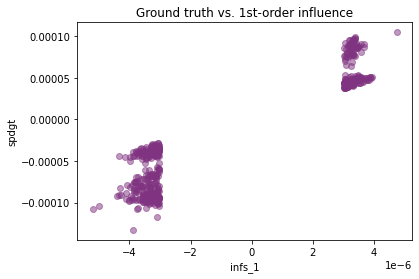

In [21]:
colors = (0.5,0.2,0.5)
# area = np.pi*3

# Plot
plt.scatter(infs_500, spdgt_500, c=colors, alpha=0.5)
plt.title('Ground truth vs. 1st-order influence')
plt.xlabel('infs_1')
plt.ylabel('spdgt')
plt.show()

**Checking ground truth, first-order and second-order influences for a set**

In [26]:
# ground truth predicates
predicates = ['marital_Married-civ-spouse']

# 1st-order influence predicates
predicates = ['occupation_Armed-Forces', 'relationship_Not-in-family', 'education.num', 'marital_Married-spouse-absent']
predicates = ['relationship_Not-in-family', 'occupation_Tech-support']
predicates = ['workclass_Private', 'occupation_Handlers-cleaners', 'race_Black', 'occupation_Other-service', 'marital_Divorced', 'race_Other', 'occupation_Protective-serv', 'relationship_Wife', 'occupation_Sales', 'relationship_Husband', 'hours', 'marital_Never-married', 'relationship_Own-child', 'marital_Married-spouse-absent', 'occupation_Exec-managerial', 'marital_Married-civ-spouse', 'occupation_Tech-support', 'race_Asian-Pac-Islander', 'occupation_Farming-fishing', 'marital_Married-AF-spouse', 'relationship_Other-relative', 'workclass_Self-emp-not-inc', 'marital_Separated', 'race_White', 'workclass_Federal-gov', 'marital_Widowed', 'occupation_Prof-specialty', 'relationship_Unmarried', 'education.num', 'workclass_State-gov', 'occupation_Transport-moving', 'gender_Male', 'workclass_Local-gov', 'occupation_Craft-repair', 'relationship_Not-in-family', 'occupation_Priv-house-serv']

idx = X_train_orig[(X_train_orig[predicates[0]] == 1)
#                    & (X_train_orig[predicates[1]] == 1) 
#                    & (X_train_orig[predicates[2]] == 1)
#                    & (X_train_orig[predicates[3]] == 1)
                  ].index 

print(len(idx))

X = np.delete(X_train, idx, 0)
y = y_train.drop(index=idx, inplace=False)
clf.fit(X, y)
y_pred_test = clf.predict_proba(X_test)
print("Ground truth influence: ", computeFairness(y_pred_test, X_test_orig) - spd_0)

del_f = 0
for i in range(len(idx)):
    del_f += infs_1[idx[i]]
print("First-order influence: ", del_f)

# print("Second-order influence: ", second_order_influence(X_train, hinv_v, idx, size_hvp, del_L_del_theta, hessian_all_points))

22286
Ground truth influence:  0.016080198794457323
First-order influence:  0.0001967901656447351


**Greedy heuristic for selecting attributes**

In [22]:
#method=1 (retrain), 2 (first-order), 3 (second-order)
def getInfluenceOfSet(indices, method, f, size, infs, v1, del_L_del_theta,
                      X_train, y_train, X_test, X_test_orig): 
    del_f = 0
    if (method == 1):
        X = np.delete(X_train, indices, 0)
        y = y_train.drop(index=indices, inplace=False)
        clf.fit(X, y)
        y_pred = clf.predict_proba(X_test)
        del_f = computeFairness(y_pred, X_test_orig) - f
    elif (method == 2):
        for i in range(len(indices)):
            del_f += infs[indices[i]]
    elif (method == 3):
        del_f = second_order_influence(X_train, v1, indices, size, del_L_del_theta, hessian_all_points)
    return del_f
        
def getAttribute(method, f, size, infs, attrList, v1, cols, del_L_del_theta,
                 X_train, y_train, X_train_orig, X_test, X_test_orig):
    attrK = None
    attrKval = None
    f_curr = f
    indices = []
    print(f_curr)
    cols = list(set(cols) - set(attrList))
    
    X_train_pred = copy.deepcopy(X_train_orig)
    for i in range(len(attrList)):
#         print(i)
        X_train_pred = X_train_orig[X_train_orig[attrList[i]] == 1]
    
    for col in cols:
        print("Attribute: ", col)
        indices = X_train_pred[X_train_pred[col] == 1].index      
        
        del_f = getInfluenceOfSet(indices, method, f_curr, size, infs, v1, del_L_del_theta,
                      X_train, y_train, X_test, X_test_orig)
        print("Influence of set: ", del_f)
        
        f_col = f_curr + del_f
        print("Del_f: ", del_f)
        print("f_col: ", f_col)
        
#         if ((del_f > 0) and (abs(f_col) > threshold) and (abs(f_col) < abs(f_curr))):
        if ((abs(f_col) > threshold) and (abs(f_col) < abs(f_curr))):
            attrK = col
            f_curr = f_col
            print("Attribute passed: ", attrK)
            print("f: ", f_curr)
    
    return [attrK, f_curr]

def getPredicates(method, f_0, size, infs, v1, del_L_del_theta,
                  X_train, y_train, X_train_orig, X_test, X_test_orig):    
    attrList = []
    found = True
    f_curr = f_0
    depth=0
    k = len(X_train_orig.columns)
    while (k > 0 and found):
        print("Depth: ", depth)
        depth += 1
        found = False
        results = getAttribute(method, f_curr, size, infs, attrList, v1, X_train_orig.columns,
                               del_L_del_theta, X_train, y_train, X_train_orig, X_test, X_test_orig)
    
        attrK = results[0]
        f = results[1]
        
        if (attrK is not None):
            attrList.insert(len(attrList), attrK)
            f_curr = f
            print("Selected k: ", attrK)
            print("f: ", f)
            found = True
            
    return attrList

In [23]:
# Get predicates on training data
# method = 1 (retrain), 2 (first-order), 3 (second-order)
method = 2
attrList = getPredicates(method, spd_0, size_hvp, infs_1, hinv_v, del_L_del_theta,
                 X_train, y_train, X_train_orig, X_test, X_test_orig)

print(attrList)

Depth:  0
-0.20059371090978573
Attribute:  occupation_Armed-Forces
Influence of set:  8.196010185146456e-07
Del_f:  8.196010185146456e-07
f_col:  -0.2005928913087672
Attribute passed:  occupation_Armed-Forces
f:  -0.2005928913087672
Attribute:  gender_Female
Influence of set:  1.808955618926223e-05
Del_f:  1.808955618926223e-05
f_col:  -0.20057480175257794
Attribute passed:  gender_Female
f:  -0.20057480175257794
Attribute:  workclass_Self-emp-inc
Influence of set:  6.723518706706959e-06
Del_f:  6.723518706706959e-06
f_col:  -0.20056807823387124
Attribute passed:  workclass_Self-emp-inc
f:  -0.20056807823387124
Attribute:  workclass_Local-gov
Influence of set:  2.699243849105216e-05
Del_f:  2.699243849105216e-05
f_col:  -0.2005410857953802
Attribute passed:  workclass_Local-gov
f:  -0.2005410857953802
Attribute:  gender_Male
Influence of set:  -1.7559605186128515e-05
Del_f:  -1.7559605186128515e-05
f_col:  -0.2005586454005663
Attribute:  occupation_Craft-repair
Influence of set:  -4.16

Influence of set:  -8.593493909543261e-06
Del_f:  -8.593493909543261e-06
f_col:  -0.19865819476541663
Attribute:  relationship_Wife
Influence of set:  5.3144783173406706e-05
Del_f:  5.3144783173406706e-05
f_col:  -0.19859645648833366
Attribute passed:  relationship_Wife
f:  -0.19859645648833366
Attribute:  occupation_Other-service
Influence of set:  -2.2335318593119407e-05
Del_f:  -2.2335318593119407e-05
f_col:  -0.19861879180692676
Attribute:  marital_Married-spouse-absent
Influence of set:  6.506142435803744e-07
Del_f:  6.506142435803744e-07
f_col:  -0.19859580587409006
Attribute passed:  marital_Married-spouse-absent
f:  -0.19859580587409006
Attribute:  race_Black
Influence of set:  9.366358022318516e-05
Del_f:  9.366358022318516e-05
f_col:  -0.19850214229386687
Attribute passed:  race_Black
f:  -0.19850214229386687
Attribute:  occupation_Handlers-cleaners
Influence of set:  8.131076511022995e-06
Del_f:  8.131076511022995e-06
f_col:  -0.19849401121735585
Attribute passed:  occupatio

Influence of set:  -1.359554889808011e-09
Del_f:  -1.359554889808011e-09
f_col:  -0.19789718355012187
Attribute:  relationship_Not-in-family
Influence of set:  1.7932797501605139e-06
Del_f:  1.7932797501605139e-06
f_col:  -0.19789538891081682
Attribute passed:  relationship_Not-in-family
f:  -0.19789538891081682
Attribute:  marital_Widowed
Influence of set:  -5.2979556814005555e-06
Del_f:  -5.2979556814005555e-06
f_col:  -0.19790068686649823
Attribute:  workclass_Federal-gov
Influence of set:  -4.7243849116327015e-06
Del_f:  -4.7243849116327015e-06
f_col:  -0.19790011329572846
Attribute:  education.num
Influence of set:  -1.5913500370317828e-07
Del_f:  -1.5913500370317828e-07
f_col:  -0.19789554804582052
Attribute:  marital_Separated
Influence of set:  1.3677249675878338e-06
Del_f:  1.3677249675878338e-06
f_col:  -0.19789402118584923
Attribute passed:  marital_Separated
f:  -0.19789402118584923
Attribute:  occupation_Exec-managerial
Influence of set:  0
Del_f:  0
f_col:  -0.19789402118

f:  -0.19755523284316015
Selected k:  occupation_Protective-serv
f:  -0.19755523284316015
Depth:  7
-0.19755523284316015
Attribute:  occupation_Armed-Forces
Influence of set:  0
Del_f:  0
f_col:  -0.19755523284316015
Attribute:  gender_Female
Influence of set:  -7.691362176426012e-06
Del_f:  -7.691362176426012e-06
f_col:  -0.19756292420533658
Attribute:  workclass_Self-emp-inc
Influence of set:  -1.9748406863194607e-06
Del_f:  -1.9748406863194607e-06
f_col:  -0.19755720768384646
Attribute:  workclass_Local-gov
Influence of set:  7.401219838369956e-05
Del_f:  7.401219838369956e-05
f_col:  -0.19748122064477644
Attribute passed:  workclass_Local-gov
f:  -0.19748122064477644
Attribute:  gender_Male
Influence of set:  -1.2747865424126838e-05
Del_f:  -1.2747865424126838e-05
f_col:  -0.19749396851020057
Attribute:  occupation_Craft-repair
Influence of set:  0
Del_f:  0
f_col:  -0.19748122064477644
Attribute:  occupation_Transport-moving
Influence of set:  0
Del_f:  0
f_col:  -0.19748122064477

Influence of set:  5.465714949369596e-06
Del_f:  5.465714949369596e-06
f_col:  -0.1972165962977665
Attribute passed:  marital_Separated
f:  -0.1972165962977665
Attribute:  occupation_Exec-managerial
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  occupation_Prof-specialty
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  occupation_Farming-fishing
Influence of set:  0
Del_f:  0
f_col:  -0.1972165962977665
Attribute:  race_White
Influence of set:  8.523127818822061e-05
Del_f:  8.523127818822061e-05
f_col:  -0.1971313650195783
Attribute passed:  race_White
f:  -0.1971313650195783
Attribute:  relationship_Other-relative
Influence of set:  -1.7378348367210434e-06
Del_f:  -1.7378348367210434e-06
f_col:  -0.19713310285441502
Attribute:  workclass_Self-emp-not-inc
Influence of set:  -2.7127479304370597e-05
Del_f:  -2.7127479304370597e-05
f_col:  -0.19715849249888265
Attribute:  marital_Married-civ-spouse
Influence of set:  6.593687562910461e-05
Del_

Attribute:  occupation_Armed-Forces
Influence of set:  -5.489094260036159e-09
Del_f:  -5.489094260036159e-09
f_col:  -0.1967876266700323
Attribute:  gender_Female
Influence of set:  -1.0996207631770658e-05
Del_f:  -1.0996207631770658e-05
f_col:  -0.1967986173885698
Attribute:  workclass_Self-emp-inc
Influence of set:  1.1046490182483104e-06
Del_f:  1.1046490182483104e-06
f_col:  -0.19678651653191978
Attribute passed:  workclass_Self-emp-inc
f:  -0.19678651653191978
Attribute:  workclass_Local-gov
Influence of set:  -8.350393986959547e-07
Del_f:  -8.350393986959547e-07
f_col:  -0.19678735157131846
Attribute:  gender_Male
Influence of set:  5.845721838606087e-06
Del_f:  5.845721838606087e-06
f_col:  -0.1967806708100812
Attribute passed:  gender_Male
f:  -0.1967806708100812
Attribute:  occupation_Craft-repair
Influence of set:  3.2612884129131747e-06
Del_f:  3.2612884129131747e-06
f_col:  -0.19677740952166828
Attribute passed:  occupation_Craft-repair
f:  -0.19677740952166828
Attribute:  

Influence of set:  -8.999777925324406e-07
Del_f:  -8.999777925324406e-07
f_col:  -0.19673147017627696
Attribute:  age
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  occupation_Adm-clerical
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  race_Amer-Indian-Eskimo
Influence of set:  -1.0259679513184373e-05
Del_f:  -1.0259679513184373e-05
f_col:  -0.1967408298779976
Attribute:  occupation_Machine-op-inspct
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  workclass_Without-pay
Influence of set:  0
Del_f:  0
f_col:  -0.19673057019848442
Attribute:  relationship_Not-in-family
Influence of set:  -5.400075701666e-05
Del_f:  -5.400075701666e-05
f_col:  -0.1967845709555011
Attribute:  marital_Widowed
Influence of set:  7.429703599987473e-06
Del_f:  7.429703599987473e-06
f_col:  -0.19672314049488443
Attribute passed:  marital_Widowed
f:  -0.19672314049488443
Attribute:  workclass_Federal-gov
Influence of set:  2.045542183655450

Influence of set:  -5.366635308134836e-06
Del_f:  -5.366635308134836e-06
f_col:  -0.1964023540048403
Attribute:  relationship_Other-relative
Influence of set:  1.0658920664334734e-07
Del_f:  1.0658920664334734e-07
f_col:  -0.1963968807803255
Attribute passed:  relationship_Other-relative
f:  -0.1963968807803255
Attribute:  workclass_Self-emp-not-inc
Influence of set:  -1.4709523317961235e-06
Del_f:  -1.4709523317961235e-06
f_col:  -0.1963983517326573
Selected k:  relationship_Other-relative
f:  -0.1963968807803255
Depth:  21
-0.1963968807803255
Attribute:  occupation_Armed-Forces
Influence of set:  -1.5934443973975213e-07
Del_f:  -1.5934443973975213e-07
f_col:  -0.19639704012476522
Attribute:  gender_Female
Influence of set:  -3.8102575104908755e-06
Del_f:  -3.8102575104908755e-06
f_col:  -0.19640069103783597
Attribute:  workclass_Self-emp-inc
Influence of set:  8.226312648939984e-07
Del_f:  8.226312648939984e-07
f_col:  -0.1963960581490606
Attribute passed:  workclass_Self-emp-inc
f: 

Attribute:  occupation_Armed-Forces
Influence of set:  8.196010185146456e-07
Del_f:  8.196010185146456e-07
f_col:  -0.19601460375099689
Attribute passed:  occupation_Armed-Forces
f:  -0.19601460375099689
Attribute:  gender_Female
Influence of set:  1.3526868387633927e-05
Del_f:  1.3526868387633927e-05
f_col:  -0.19600107688260926
Attribute passed:  gender_Female
f:  -0.19600107688260926
Attribute:  workclass_Self-emp-inc
Influence of set:  0
Del_f:  0
f_col:  -0.19600107688260926
Attribute:  workclass_Local-gov
Influence of set:  0
Del_f:  0
f_col:  -0.19600107688260926
Attribute:  gender_Male
Influence of set:  2.5731685993551943e-05
Del_f:  2.5731685993551943e-05
f_col:  -0.19597534519661572
Attribute passed:  gender_Male
f:  -0.19597534519661572
Attribute:  occupation_Craft-repair
Influence of set:  -1.3996678784421155e-05
Del_f:  -1.3996678784421155e-05
f_col:  -0.19598934187540015
Attribute:  occupation_Transport-moving
Influence of set:  -3.463662861933257e-06
Del_f:  -3.46366286

Attribute:  occupation_Adm-clerical
Influence of set:  1.3770791097848645e-09
Del_f:  1.3770791097848645e-09
f_col:  -0.19558285093253433
Attribute passed:  occupation_Adm-clerical
f:  -0.19558285093253433
Attribute:  occupation_Armed-Forces
Influence of set:  0
Del_f:  0
f_col:  -0.19558285093253433
Attribute:  race_Amer-Indian-Eskimo
Influence of set:  0
Del_f:  0
f_col:  -0.19558285093253433
Attribute:  occupation_Machine-op-inspct
Influence of set:  5.163756760462376e-08
Del_f:  5.163756760462376e-08
f_col:  -0.19558279929496672
Attribute passed:  occupation_Machine-op-inspct
f:  -0.19558279929496672
Attribute:  workclass_Without-pay
Influence of set:  0
Del_f:  0
f_col:  -0.19558279929496672
Attribute:  gender_Female
Influence of set:  3.244198975674469e-07
Del_f:  3.244198975674469e-07
f_col:  -0.19558247487506916
Attribute passed:  gender_Female
f:  -0.19558247487506916
Attribute:  relationship_Not-in-family
Influence of set:  -2.2516248516006355e-08
Del_f:  -2.2516248516006355e